In [1]:
try:
    import os
    os.chdir("/content/sample_data")
    os.mkdir('croped_frames')
    os.mkdir('finial_video')
    os.mkdir('frames')
    os.mkdir('video')
    os.mkdir('video_without_sound')
except:
    pass

In [2]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 46.2 MB/s eta 0:00:00


In [3]:
import cv2
import os
import PIL
from PIL import Image
import pandas as pd
import numpy as np
import sys
import shutil
from google.colab.patches import cv2_imshow
from copy import deepcopy

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
a = list(os.listdir("/content/drive/MyDrive/video"))
video_name = a[0]

In [ ]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

def chunk_video(filename, chunk_size):
    from moviepy.video.io.VideoFileClip import VideoFileClip
    clip = VideoFileClip(filename)
    duration = clip.duration
    i = 0
    while i < duration:
        start_time = i
        end_time = i + chunk_size
        if end_time > duration:
            end_time = duration
        chunk_filename = f"chunk_video/{filename[:-4]}_chunk_{start_time}_{end_time}.mp4"
        # print(f"Creating {chunk_filename}")
        ffmpeg_extract_subclip(filename, start_time, end_time, targetname=chunk_filename)
        i += chunk_size

os.chdir("/content/drive/MyDrive/video")
os.mkdir('chunk_video')
chunk_video(video_name, 15)

# Converting video into frames

In [6]:
os.chdir("/content/drive/MyDrive/video/chunk_video")

for chunk_video in [os.listdir()[3]]:
    vidcap = cv2.VideoCapture(chunk_video)
    success, image = vidcap.read()
    count = 0

    while success:
        # specify frame path for each video
        frame_dir = "/content/sample_data/frames/"

        # create frame directory if it does not exist
        if not os.path.exists(frame_dir + chunk_video[:-4]):
            os.makedirs(frame_dir + chunk_video[:-4])

        frame_path = "{}{}/frame{}.jpg".format(frame_dir, chunk_video[:-4], count)
        try:
            cv2.imwrite(frame_path, image)  # save frame as JPEG file
        except Exception as e:
            print("Error: {}".format(e))  # print actual error instead of just ignoring it
            break  # stop processing on error

        success, image = vidcap.read()  # read the next frame
        if cv2.waitKey(10) == 27:
            break

        count += 1


# Croping the frames

In [7]:
def face_detection_function(image2, height, width, name1):
    results = face_detection.process(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))

    face_detection_text = []
    face_detection_edited_text = []
    face_detection_x_min = 1.0
    face_detection_x_max = 0.0

    if not results.detections:
        return face_detection_x_min, face_detection_x_max

    if results.detections:
        for detection in results.detections:
            face_detection_text = []
            face_detection_edited_text = []

            face_detection_file = open(name1+".txt", "x")
            face_detection_file.write(str(detection))
            face_detection_file.close()
            face_detection_file = open(name1+".txt", "r")

            for line in face_detection_file:
                face_detection_text.append(line)

            del face_detection_text[0:5]
            del face_detection_text[4:]

            for num in range(len(face_detection_text)):
                face_detection_edited_text.append(face_detection_text[num].strip())

            if face_detection_x_min > float(face_detection_edited_text[0][6:]):
                face_detection_x_min = float(face_detection_edited_text[0][6:])
            if face_detection_x_max < (float(face_detection_edited_text[0][6:])+float(face_detection_edited_text[2][7:])):
                face_detection_x_max = (float(face_detection_edited_text[0][6:])+float(face_detection_edited_text[2][7:]))

            face_detection_file.close()
            os.remove(name1+".txt")

        return face_detection_x_min, face_detection_x_max

In [8]:
def holistic_landmarks_function(image3, height, width, name1):
    holistic_results = holistic.process(cv2.cvtColor(image3, cv2.COLOR_BGR2RGB))

    holistic_landmarks_text = []

    holistic_face_landmarks_x_min = 1.0
    holistic_face_landmarks_x_max = 0.0
    holistic_face_landmarks_x_min_next = 1.0
    holistic_face_landmarks_x_max_next = 0.0

    holistic_pose_landmarks_x_min = 1.0
    holistic_pose_landmarks_x_max = 0.0
    holistic_pose_landmarks_x_min_next = 1.0
    holistic_pose_landmarks_x_max_next = 0.0

    if not holistic_results.face_landmarks:
        return holistic_face_landmarks_x_min, holistic_face_landmarks_x_max, holistic_pose_landmarks_x_min, holistic_pose_landmarks_x_max

    elif holistic_results.face_landmarks:
        holistic_results_file = open(name1+".txt", "x")
        holistic_results_file.write(str(holistic_results.face_landmarks))
        holistic_results_file.close()
        holistic_results_file = open(name1+".txt", "r")

        for line in holistic_results_file:
            holistic_landmarks_text.append(line)

        for num in range(len(holistic_landmarks_text)):
            if 'x' in holistic_landmarks_text[num]:
                if holistic_face_landmarks_x_min > float(holistic_landmarks_text[num].strip()[3:]):
                    holistic_face_landmarks_x_min = float(holistic_landmarks_text[num].strip()[3:])

                if holistic_face_landmarks_x_max < float(holistic_landmarks_text[num].strip()[3:]):
                    holistic_face_landmarks_x_max = float(holistic_landmarks_text[num].strip()[3:])

        holistic_results_file.close()
        os.remove(name1+".txt")

        holistic_landmarks_text = []

        holistic_results_file = open(name1+".txt", "x")
        holistic_results_file.write(str(holistic_results.pose_landmarks))
        holistic_results_file.close()
        holistic_results_file = open(name1+".txt", "r")

        for line in holistic_results_file:
            holistic_landmarks_text.append(line)

        for num in range(len(holistic_landmarks_text)):
            if 'x' in holistic_landmarks_text[num]:
                if holistic_pose_landmarks_x_min > float(holistic_landmarks_text[num].strip()[3:]):
                    holistic_pose_landmarks_x_min = float(holistic_landmarks_text[num].strip()[3:])

                if holistic_pose_landmarks_x_max < float(holistic_landmarks_text[num].strip()[3:]):
                    holistic_pose_landmarks_x_max = float(holistic_landmarks_text[num].strip()[3:])

        holistic_results_file.close()
        os.remove(name1+".txt")

    image3[:, int(holistic_face_landmarks_x_min*width):int(holistic_face_landmarks_x_max*width)] = (0, 0, 0)
    holistic_face_landmarks_x_min_next, holistic_face_landmarks_x_max_next, holistic_pose_landmarks_x_min_next, holistic_pose_landmarks_x_max_next = holistic_landmarks_function(image3, height, width, name1)

    if holistic_face_landmarks_x_min > holistic_face_landmarks_x_min_next:
        holistic_face_landmarks_x_min = holistic_face_landmarks_x_min_next

    if holistic_face_landmarks_x_max < holistic_face_landmarks_x_max_next:
        holistic_face_landmarks_x_max = holistic_face_landmarks_x_max_next

    if ((holistic_pose_landmarks_x_max-holistic_pose_landmarks_x_min)*width) <= ((9*height)/16):
        if holistic_pose_landmarks_x_min > holistic_pose_landmarks_x_min_next:
            holistic_pose_landmarks_x_min = holistic_pose_landmarks_x_min_next

        if holistic_pose_landmarks_x_max < holistic_pose_landmarks_x_max_next:
            holistic_pose_landmarks_x_max = holistic_pose_landmarks_x_max_next

    if ((holistic_pose_landmarks_x_max-holistic_pose_landmarks_x_min)*width) > ((9*height)/16):
        holistic_pose_landmarks_x_min = 1.0
        holistic_pose_landmarks_x_max = 0.0

    return holistic_face_landmarks_x_min, holistic_face_landmarks_x_max, holistic_pose_landmarks_x_min, holistic_pose_landmarks_x_max

In [9]:
def negative(left, right, width):
    left = max(0, left)
    right = min(width, right)

    if left > right:
        left = max(0, right - left)

    return left, right

In [10]:
import mediapipe as mp

mp_face_detection = mp.solutions.face_detection
mp_holistic = mp.solutions.holistic

In [11]:
base_dir = "/content/sample_data/frames/"
chunk_video_frames = os.listdir(base_dir)[0]
chunk_dir = os.path.join(base_dir, chunk_video_frames)
filenames = list(os.listdir(chunk_dir))

# A key lambda function to get the numeric value for sorting
sort_key = lambda filename: int(filename[5:-4])

# Sorted filenames in ascending order
filenames = sorted(filenames, key=sort_key)

In [12]:
os.chdir(chunk_dir)

In [13]:
all_frames_in_pixel = []
frames_shape = []
for name in filenames:
    image = cv2.imread(name)
    all_frames_in_pixel.append(image)
    height, width, color = image.shape
    frames_shape.append([height, width, color])

In [14]:
all_frames_in_pixel_cutted = deepcopy(all_frames_in_pixel)

In [15]:
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)
holistic = mp_holistic.Holistic(static_image_mode=True, min_detection_confidence=0.5)
face_detection_size = []
holistic_size = []
for num5 in range(len(filenames)):
    name1 = filenames[num5][:-4]
    image4 = all_frames_in_pixel_cutted[num5]
    height, width, color = frames_shape[num5]

    face_detection_size.append(list(face_detection_function(image4, height, width, name1)))

    holistic_size.append(list(holistic_landmarks_function(image4,height, width, name1)))


In [16]:
# different_bg_frames = []
frames_having_different_background = []
num_of_diff_bg_frames = 0
orb_detector = cv2.ORB_create()
frame_index = 0
total_frames = len(filenames)

def detect_and_compute(frame_index):
    image = all_frames_in_pixel[frame_index]
    return orb_detector.detectAndCompute(image, None)

while frame_index < total_frames - 1:
    num_of_diff_bg_frames += 1
    frame_keypoints, frame_descriptor = detect_and_compute(frame_index)

    matching_points = []
    frame_matching_condition = True

    bf_matcher = cv2.BFMatcher()

    while frame_matching_condition:
        try:
            frames_having_different_background.append(num_of_diff_bg_frames)
            next_frame_keypoints, next_frame_descriptor = detect_and_compute(frame_index + 1)
            matches = bf_matcher.knnMatch(frame_descriptor, next_frame_descriptor, k=2)

            good_ratio = 0.7
            matching_points = [m for m, n in matches if m.distance < good_ratio * n.distance]

            frame_index += 1
            frame_matching_condition = len(matching_points) > 1 and frame_index < total_frames
        except IndexError:
            frame_matching_condition = False

ans = True
while ans:
    start_changing = False
    new_list = []
    ans = False
    for number in frames_having_different_background:
        if start_changing:
            new_list.append(number - 1)
        else:
            if frames_having_different_background.count(number) == 2:
                start_changing = True
                ans = True
                new_list.append(number - 1)
            else:
                new_list.append(number)
    frames_having_different_background = new_list

In [21]:
frames_having_different_background

[1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,


In [18]:
pad_size = []
frames_size = []

for num in range(len(filenames)):
    frames_x_min = 1.0
    frames_x_max = 0.0

    need = 0

    top = frames_shape[num][0]

    actual_width = frames_shape[num][0] * 9 / 16

    if any(i < 1.0 for i in [face_detection_size[num][0], holistic_size[num][0], holistic_size[num][2]]):
        frames_x_min = min(face_detection_size[num][0], holistic_size[num][0], holistic_size[num][2])

    if any(i > 0.0 for i in [face_detection_size[num][1], holistic_size[num][1], holistic_size[num][3]]):
        frames_x_max = max(face_detection_size[num][1], holistic_size[num][1], holistic_size[num][3])

    if all(i == 1.0 for i in [face_detection_size[num][0], holistic_size[num][0], holistic_size[num][2]]):
        frames_x_min = 0.5

    if all(i == 0.0 for i in [face_detection_size[num][1], holistic_size[num][1], holistic_size[num][3]]):
        frames_x_max = 0.5

    left, right = int(frames_x_min * frames_shape[num][1]), int(frames_x_max * frames_shape[num][1])
    left, right = negative(left, right, frames_shape[num][1])

    need = abs(int((actual_width - (right - left)) / 2)) if (right - left) < actual_width else 0
    right += need
    left -= need

    pad_top_and_bottom = int((16 * (right - left - actual_width)) / 9)  if (right - left) > actual_width else 0
    left, right = negative(left, right, frames_shape[num][1])

    pad_size.append([pad_top_and_bottom, pad_top_and_bottom])
    frames_size.append([0, top, left, right])

In [22]:
start = 0
pre_left = frames_size[0][2]
pre_right = frames_size[0][3]

for i in range(1, len(frames_having_different_background)):

    if frames_having_different_background[i-1] == frames_having_different_background[i]:

        pre_left = min(frames_size[i][2], pre_left)
        pre_right = max(frames_size[i][3], pre_right)

    else:

        for num8 in range(start, i):
            frames_size[num8][2] = pre_left
            frames_size[num8][3] = pre_right

        start = i
        pre_left = frames_size[i][2]
        pre_right = frames_size[i][3]

# Update any remaining frames
for num8 in range(start, i+1):
    frames_size[num8][2] = pre_left
    frames_size[num8][3] = pre_right

bottom: 0, top: 1080, left: 657, right: 1822


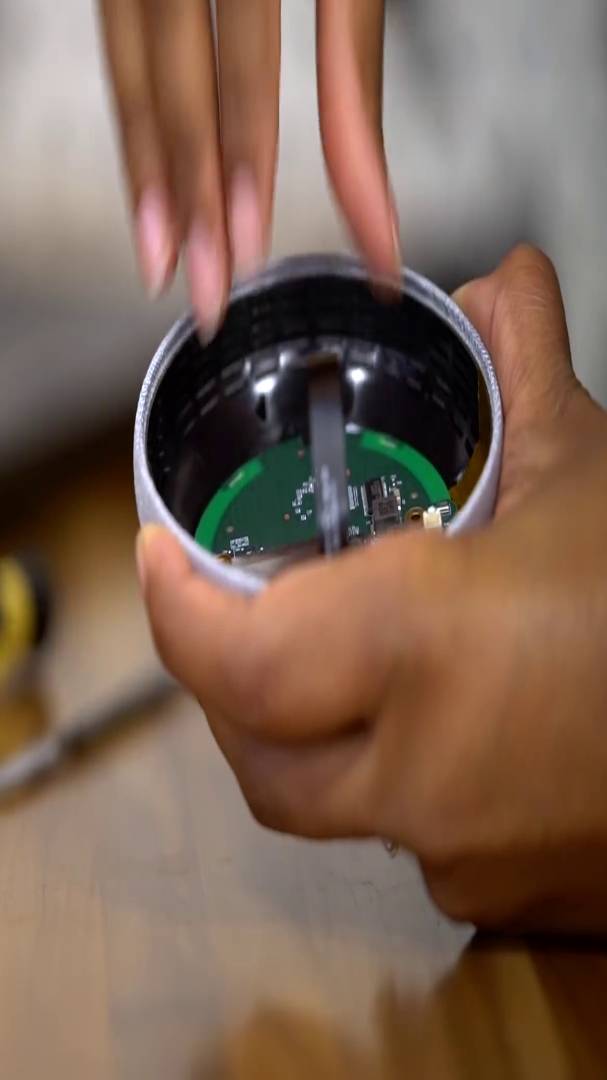

In [23]:
all_frames_in_pixel_cropped_frames = []
os.chdir(chunk_dir)

n = len(filenames)
last_frame_shape = frames_shape[n - 1]
resize_scale = int((9 * last_frame_shape[0]) / 16), last_frame_shape[0]

for num4, (image1, frame_size, frame_shape, pad) in enumerate(zip(all_frames_in_pixel, frames_size, frames_shape, pad_size)):
    if pad[0] > 0 and pad[1] > 0:
        padding_height = frame_shape[0] + sum(pad)
        padding_color = (0, 0, 0)

        image1 = cv2.copyMakeBorder(image1, *pad, 0, 0, cv2.BORDER_CONSTANT, value=padding_color)

        actual_height = (16 * (frame_size[3] - frame_size[2])) / 9
        bottom = int(max((padding_height / 2) - (actual_height / 2), 0))
        top = int((padding_height / 2) + (actual_height / 2))
    else:
        bottom, top, left, right = frame_size

    image_crop = image1[bottom:top, frame_size[2]:frame_size[3]]
    image_crop = cv2.resize(image_crop, resize_scale)

    if num4 == 18:
        print(f"bottom: {bottom}, top: {top}, left: {frame_size[2]}, right: {frame_size[3]}")
        cv2_imshow(image_crop)

    all_frames_in_pixel_cropped_frames.append(image_crop)

# Duration of a video file

In [24]:
import moviepy.editor
#video_name = "vlc-record-2021-04-29-17h30m48s-What's it like to work at Google 1080 x 1920.mp4-.mp4"
# Converts into more readable format
def convert(seconds):
    hours = seconds // 3600
    seconds %= 3600

    mins = seconds // 60
    seconds %= 60

    return hours, mins, seconds


# Create an object by passing the location as a string
os.chdir("/content/drive/MyDrive/video/chunk_video")
video = moviepy.editor.VideoFileClip(os.listdir()[3])

# Contains the duration of the video in terms of seconds
video_duration = int(video.duration)

hours, mins, secs = convert(video_duration)

duration_sec = hours*60*60 + mins*60 + secs

# Converting frames into video

In [25]:
import cv2
import numpy as np
import os

#video_name = "vlc-record-2021-04-29-17h30m48s-What's it like to work at Google 1080 x 1920.mp4-.mp4"

size = ((int((9*frames_shape[0][0])/16), frames_shape[0][0]))

os.chdir("/content/sample_data/video_without_sound")
out = cv2.VideoWriter(video_name[:-4]+'.avi',cv2.VideoWriter_fourcc(*'mp4v'), int(len(filenames)/duration_sec), size)

for i in range(len(all_frames_in_pixel_cropped_frames)):
    out.write(all_frames_in_pixel_cropped_frames[i])
out.release()

# Taking audio from original video and combining with edited video

In [26]:
import moviepy.editor as mpe

os.chdir("/content/drive/MyDrive/video/chunk_video")
original_clip = mpe.VideoFileClip(os.listdir()[3])
#audio_bg = mpe.AudioFileClip("input/shakiraHips.mp3")

os.chdir("/content/sample_data/video_without_sound")
ouput_clip = mpe.VideoFileClip(video_name[:-4]+'.avi')
#final_audio = mpe.CompositeAudioClip([audio_bg, clip.audio])

final_clip = ouput_clip.set_audio(original_clip.audio)
os.chdir("/content/drive/MyDrive/finial_video")
final_clip.write_videofile(video_name[:-4]+".mp4")


Moviepy - Building video Whats it like to work at Google_1080p.mp4.
MoviePy - Writing audio in Whats it like to work at Google_1080pTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video Whats it like to work at Google_1080p.mp4



t: 100%|█████████▉| 451/452 [00:23<00:00, 10.60it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file Whats it like to work at Google_1080p.avi, 1963440 bytes wanted but 0 bytes read,at frame 451/452, at time 16.11/16.11 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready Whats it like to work at Google_1080p.mp4
